In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Datasets/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

<AxesSubplot:>

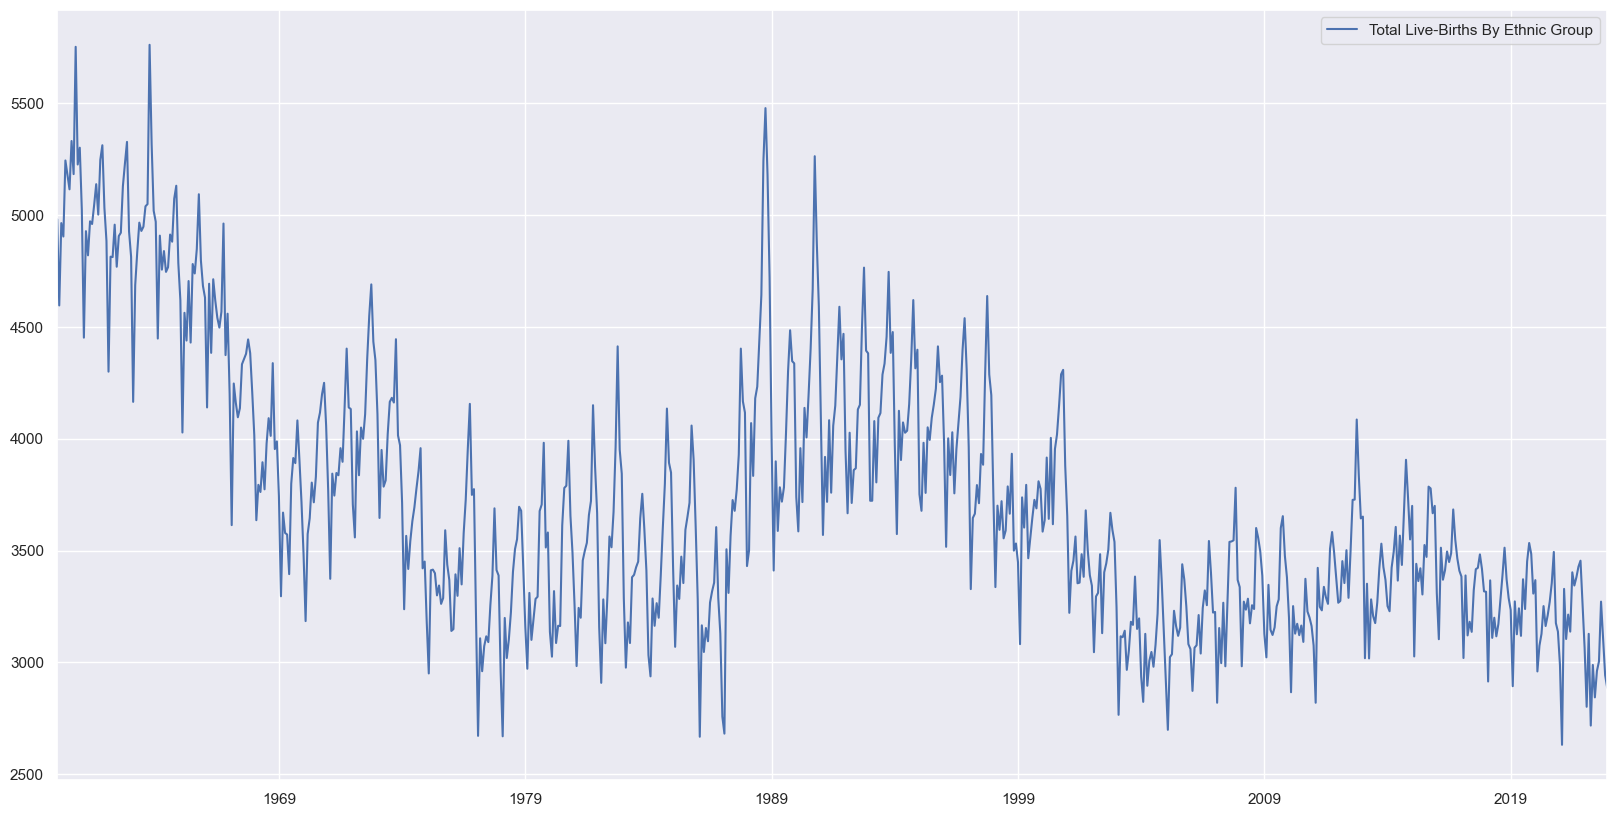

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

## Variable: Education Cost

- Standardized the date to `YYYY-MM` following the date format for the birth count dataset

In [5]:
# Variable: Education Costs
edu = pd.read_csv("Datasets/Education_clean.csv")
edu = edu.rename(columns = {'Data Series':'Date','Education':'Total'})
birthData = birthData.rename(columns=lambda x: x.strip())
edu['Date'] = pd.to_datetime(edu['Date'])
edu['Date'] = edu['Date'].dt.strftime('%Y-%m')

edu = edu.set_index('Date')
edu.index = pd.to_datetime(edu.index).to_period('M')
# Set missing 'na' data to 0
edu = edu.fillna(0)
edu.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 745 entries, 2023-01 to 1961-01
Freq: M
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Total                                745 non-null    float64
 1   Tuition & Other Fees (Extrapolated)  745 non-null    float64
 2   Textbooks & Guides (Extrapolated)    745 non-null    float64
 3   Tuition & Other Fees                 745 non-null    float64
 4   Textbooks & Guides                   745 non-null    float64
dtypes: float64(5)
memory usage: 34.9 KB


- Missing data of `Tuition & Other Fees` and `Textbook & Guides` before 2000 were extrapolated using the same trend as the `Total` variable
- Acceptable extrapolation as `Total` would be based on `Tuition & Other Fees` and `Textbook & Guides`, meaning that the components of `Total` were only identified from 2000 onwards 
- Formula: Current Tuition Fee = Previous Tuition Fee*(Total of Current Year/Total of Previous Year)

<AxesSubplot:xlabel='Date'>

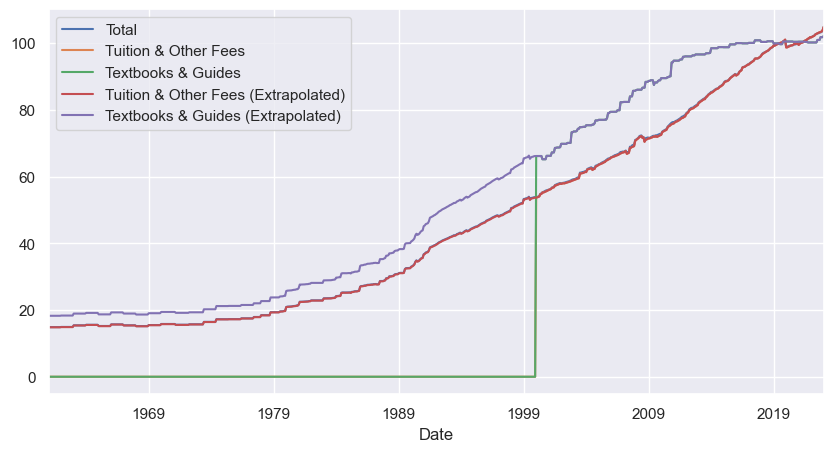

In [6]:
eduMerge = pd.concat([edu['Total'], edu['Tuition & Other Fees'], edu['Textbooks & Guides'], edu['Tuition & Other Fees (Extrapolated)'], edu['Textbooks & Guides (Extrapolated)']], axis=1, join='inner')
eduMerge = eduMerge.loc[:,~eduMerge.columns.duplicated(keep='first')]
eduMerge.plot(figsize=(10, 5))

<AxesSubplot:>

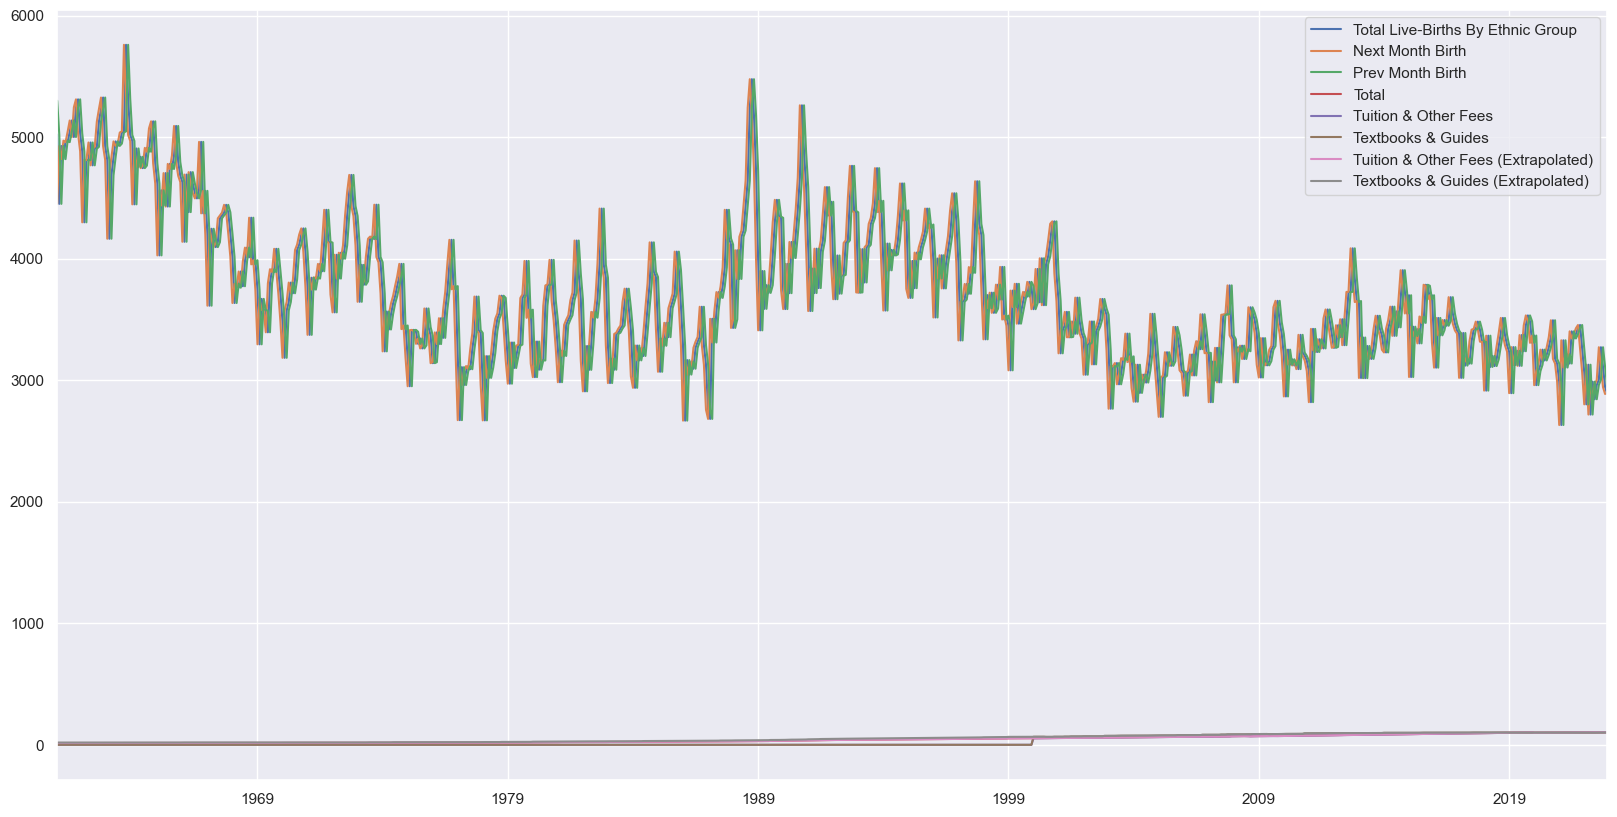

In [7]:
eduBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
eduBaby['Next Month Birth'] = eduBaby['Total Live-Births By Ethnic Group'].shift(-1)
eduBaby['Prev Month Birth'] = eduBaby['Total Live-Births By Ethnic Group'].shift(1)
eduTotal = eduBaby.join(edu['Total'], how='inner')
eduTuition = eduBaby.join(edu['Tuition & Other Fees'], how='inner')
eduText = eduBaby.join(edu['Textbooks & Guides'], how='inner')
eduTuitionEx = eduBaby.join(edu['Tuition & Other Fees (Extrapolated)'], how='inner')
eduTextEx = eduBaby.join(edu['Textbooks & Guides (Extrapolated)'], how='inner')
eduMerge = pd.concat([eduTotal, eduTuition, eduText, eduTuitionEx, eduTextEx], axis=1, join='inner')
eduMerge = eduMerge.loc[:,~eduMerge.columns.duplicated(keep='first')]
eduMerge.plot(figsize=(20, 10))

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 744 entries, 1961-01 to 2022-12
Freq: M
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Total Live-Births By Ethnic Group    744 non-null    int64  
 1   Next Month Birth                     743 non-null    float64
 2   Prev Month Birth                     744 non-null    float64
 3   Total                                744 non-null    float64
 4   Tuition & Other Fees                 744 non-null    float64
 5   Textbooks & Guides                   744 non-null    float64
 6   Tuition & Other Fees (Extrapolated)  744 non-null    float64
 7   Textbooks & Guides (Extrapolated)    744 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 68.5 KB


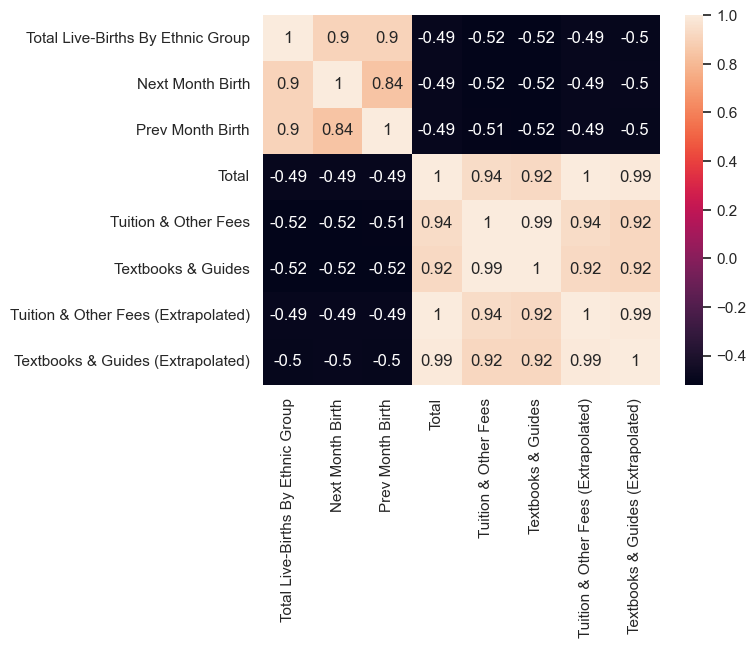

In [8]:
eduMerge.info()
eduMerge.corr()
corr_matrix = eduMerge.corr()
sb.heatmap(corr_matrix, annot=True)
plt.show()

## Analysis
- Non extrapolated data of `Tuition & Other Fees` and `Textbook & Guides` showed higher correlation compared to being extrapolated
- However, non extrapolated data of `Tuition & Other Fees` and `Textbook & Guides` removed as it might show innacurate correlations if the missing data points are taken to be 0

In [9]:
eduUpdate = pd.concat([eduTotal,eduTuitionEx, eduTextEx], axis=1, join='inner')
eduUpdate = eduUpdate.loc[:,~eduUpdate.columns.duplicated(keep='first')]
eduUpdate.info()
eduUpdate.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 744 entries, 1961-01 to 2022-12
Freq: M
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Total Live-Births By Ethnic Group    744 non-null    int64  
 1   Next Month Birth                     743 non-null    float64
 2   Prev Month Birth                     744 non-null    float64
 3   Total                                744 non-null    float64
 4   Tuition & Other Fees (Extrapolated)  744 non-null    float64
 5   Textbooks & Guides (Extrapolated)    744 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 56.9 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,Total,Tuition & Other Fees (Extrapolated),Textbooks & Guides (Extrapolated)
Total Live-Births By Ethnic Group,1.000000,0.900852,0.901578,-0.494433,-0.494225,-0.496801
Next Month Birth,0.900852,1.000000,0.841425,-0.493073,-0.492833,-0.495441
Prev Month Birth,0.901578,0.841425,1.000000,-0.493594,-0.493351,-0.496358
Total,-0.494433,-0.493073,-0.493594,1.000000,0.999994,0.989936
Tuition & Other Fees (Extrapolated),-0.494225,-0.492833,-0.493351,0.999994,1.000000,0.989530
Textbooks & Guides (Extrapolated),-0.496801,-0.495441,-0.496358,0.989936,0.989530,1.000000


## Classification: Random Forest vs Logistic Regression
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - Total/Tuition(Extrapolated)/Textbooks(Extrapolated)
    
## Performance Evaluation Technique: K-Fold vs Leave-One-Out
- Leave-one-out too computational expensive, going for K-Fold instead
- Since dataset is small (About 300+ data points), use a smaller fold number (3)
- This gives about 100+ data points for each fold

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [10]:
# Step 1: Create binary target variable
eduUpdate['Rise-Fall'] = (eduUpdate['Total Live-Births By Ethnic Group'] > eduUpdate['Next Month Birth']).astype(int)

In [11]:
resultsRf = []

for i in range(100):
    # Defining number of folds for cross-validation
    num_folds = 3
    
    # Defining random seed
    seed = random.randint(0, 100000)
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = eduUpdate[['Total Live-Births By Ethnic Group',
                   'Prev Month Birth', 'Total', 'Tuition & Other Fees (Extrapolated)', 'Textbooks & Guides (Extrapolated)']]

    # Step 2.2: Response
    y = eduUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

# Sort results by F1 score in descending order
resultsRf.sort(key=lambda x: x[7], reverse=True)

In [12]:
resultsLr = []

for i in range(5):
    seed = resultsRf[i][0]
    kResLr = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lr = LogisticRegression(max_iter=1000, solver='liblinear')
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr)
        recall_lr = recall_score(y_test, y_pred_lr)
        f1_lr = f1_score(y_test, y_pred_lr)
        kResLr.append((fold, accuracy_lr, precision_lr, recall_lr, f1_lr))
        
    acc_mean_lr, acc_std_lr = np.mean([r[1] for r in kResLr]), np.std([r[1] for r in kResLr])
    prec_mean_lr, prec_std_lr = np.mean([r[2] for r in kResLr]), np.std([r[2] for r in kResLr])
    rec_mean_lr, rec_std_lr = np.mean([r[3] for r in kResLr]), np.std([r[3] for r in kResLr])
    f1_mean_lr, f1_std_lr = np.mean([r[4] for r in kResLr]), np.std([r[4] for r in kResLr])   
    resultsLr.append((seed, acc_mean_lr, acc_std_lr, prec_mean_lr, prec_std_lr, rec_mean_lr, rec_std_lr, f1_mean_lr, f1_std_lr))

In [13]:
topResultsRf = resultsRf[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {topResultsRf[i][0]}:")
    print(f'Accuracy  = {topResultsRf[i][1]:.4f} +/- {topResultsRf[i][2]:.4f}  vs  {resultsLr[i][1]:.4f} +/- {resultsLr[i][2]:.4f}')
    print(f'Precision = {topResultsRf[i][3]:.4f} +/- {topResultsRf[i][4]:.4f}  vs  {resultsLr[i][3]:.4f} +/- {resultsLr[i][4]:.4f}')
    print(f'Recall    = {topResultsRf[i][5]:.4f} +/- {topResultsRf[i][6]:.4f}  vs  {resultsLr[i][5]:.4f} +/- {resultsLr[i][6]:.4f}')
    print(f'F1 score  = {topResultsRf[i][7]:.4f} +/- {topResultsRf[i][8]:.4f}  vs  {resultsLr[i][7]:.4f} +/- {resultsLr[i][8]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 38337:
Accuracy  = 0.6774 +/- 0.0087  vs  0.5914 +/- 0.0166
Precision = 0.6719 +/- 0.0369  vs  0.5843 +/- 0.0570
Recall    = 0.6381 +/- 0.0072  vs  0.5394 +/- 0.0395
F1 score  = 0.6538 +/- 0.0134  vs  0.5570 +/- 0.0135
----------------------------------------------
Random state 86619:
Accuracy  = 0.6707 +/- 0.0288  vs  0.5914 +/- 0.0166
Precision = 0.6611 +/- 0.0193  vs  0.5843 +/- 0.0570
Recall    = 0.6383 +/- 0.0502  vs  0.5394 +/- 0.0395
F1 score  = 0.6491 +/- 0.0346  vs  0.5570 +/- 0.0135
----------------------------------------------
Random state 80781:
Accuracy  = 0.6573 +/- 0.0087  vs  0.5914 +/- 0.0166
Precision = 0.6390 +/- 0.0344  vs  0.5843 +/- 0.0570
Recall    = 0.6618 +/- 0.0406  vs  0.5394 +/- 0.0395
F1 score  = 0.6482 +/- 0.0102  vs  0.5570 +/- 0.0135
----------------------------------------------
Random state 63033:
Accuracy  = 0.6720 +/- 0.0264  vs  0.5914 +/- 0.0166
Precision = 0.6662 +/- 0.0352  vs  0.5843 +

In [14]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  vs  {sum([i[1] for i in resultsLr])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  vs  {sum([i[3] for i in resultsLr])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  vs  {sum([i[5] for i in resultsLr])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  vs  {sum([i[7] for i in resultsLr])/5:.4f}')

Average Accuracy:  0.6680  vs  0.5914
Average Precision: 0.6575  vs  0.5843
Average Recall:    0.6429  vs  0.5394
Average F1 Score:  0.6490  vs  0.5570


## Final Verdict on Models
The logistic regression has been constanly doing worse than the random forest, despite using the same seed and after testing with different number of variables

Conclusion: Random forest is the better model in this case

In [15]:
resultsRf2 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = eduUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 
                   'Total','Tuition & Other Fees (Extrapolated)']]

    # Step 2.2: Response
    y = eduUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf2.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [16]:
resultsRf3 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = eduUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 
                   'Total', 'Textbooks & Guides (Extrapolated)']]

    # Step 2.2: Response
    y = eduUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf3.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [17]:
resultsRf4 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = eduUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 
                   'Tuition & Other Fees (Extrapolated)', 'Textbooks & Guides (Extrapolated)']]

    # Step 2.2: Response
    y = eduUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf4.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [18]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[1] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf4])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[3] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf4])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[5] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf4])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[7] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf4])/5:.4f}')

Average Accuracy:  0.6680        vs  0.6586       vs  0.6602       vs  0.6591
Average Precision: 0.6575        vs  0.6507       vs  0.6502       vs  0.6476
Average Recall:    0.6429        vs  0.6246       vs  0.6315       vs  0.6361
Average F1 Score:  0.6490        vs  0.6360       vs  0.6397       vs  0.6405


## Accuracy
1. All
2. Total and Tuition & Other Fees (Extrapolated)
3. Total and Textbooks & Guides (Extrapolated)
4. Tuition & Other Fees (Extrapolated) and Textbooks & Guides (Extrapolated)

## Precision
1. All
2. Total and Tuition & Other Fees (Extrapolated)
3. Total and Textbooks & Guides (Extrapolated)
4. Tuition & Other Fees (Extrapolated) and Textbooks & Guides (Extrapolated)

## Recall
1. All
2. Total and Tuition & Other Fees (Extrapolated)
3. Total and Textbooks & Guides (Extrapolated)
4. Tuition & Other Fees (Extrapolated) and Textbooks & Guides (Extrapolated)

## F1 Score
1. All
2. Total and Tuition & Other Fees (Extrapolated)
3. Total and Textbooks & Guides (Extrapolated)
4. Tuition & Other Fees (Extrapolated) and Textbooks & Guides (Extrapolated)

## Final Verdict on Variables
Overall, keeping all variables gives the best model

As for the other 3
- Keeping the total as a factor with another of its component yields lower correlation
- Having the components by themselves yield higher correlation

Conclusion: Keep `Total` and all of its components `Tuition & Other Fees (Extrapolated)` and `Textbook & Guides (Extrapolated)`

Education costs might not be a strong factor to use to predict birth rate given its lower correlation of 0.66

It is worth noting that education costs do not add up much compared to other factors for household expenses, thus can possibly be a factor to omit in predictions